In [1]:
"""
DCGAN Baseline for Quantum Hackathon (Problem Statement 3)
Author: Varun E
Description:
  - Trains a Deep Convolutional GAN (DCGAN) on MNIST dataset.
  - Produces sharper image generations than VAE baseline.
  - Saves generated images every few epochs.
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

# -----------------------------
# 🔧 Configuration
# -----------------------------
BATCH_SIZE = 128
EPOCHS = 30
LR = 0.0002
Z_DIM = 100
IMG_CHANNELS = 1
FEATURES_GEN = 64
FEATURES_DISC = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_DIR = "results_dcgan"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------
# 📦 Data Loading
# -----------------------------
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# -----------------------------
# 🧠 Model Definitions
# -----------------------------
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, features_g * 8, 4, 1, 0),
            # State: N x (features_g*8) x 4 x 4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            # State: N x (features_g*4) x 8 x 8
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            # State: N x (features_g*2) x 16 x 16
            self._block(features_g * 2, features_g, 4, 2, 1),
            # State: N x features_g x 32 x 32
            nn.ConvTranspose2d(features_g, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output: N x 1 x 64 x 64
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x 1 x 64 x 64
            nn.Conv2d(img_channels, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, 4, 1, 0),
            nn.Sigmoid()  # Output: scalar probability
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.net(x)


# -----------------------------
# 🧩 Initialize weights
# -----------------------------
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)


# -----------------------------
# 🚀 Training
# -----------------------------
def train_dcgan():
    gen = Generator(Z_DIM, IMG_CHANNELS, FEATURES_GEN).to(DEVICE)
    disc = Discriminator(IMG_CHANNELS, FEATURES_DISC).to(DEVICE)
    gen.apply(weights_init)
    disc.apply(weights_init)

    opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=LR, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    fixed_noise = torch.randn(64, Z_DIM, 1, 1).to(DEVICE)

    print("🚀 Training DCGAN on MNIST...")
    for epoch in range(EPOCHS):
        for batch_idx, (real, _) in enumerate(loader):
            real = real.to(DEVICE)
            noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(DEVICE)
            fake = gen(noise)

            # -------------------------
            # Train Discriminator
            # -------------------------
            disc_real = disc(real).reshape(-1)
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake.detach()).reshape(-1)
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2

            disc.zero_grad()
            lossD.backward()
            opt_disc.step()

            # -------------------------
            # Train Generator
            # -------------------------
            output = disc(fake).reshape(-1)
            lossG = criterion(output, torch.ones_like(output))

            gen.zero_grad()
            lossG.backward()
            opt_gen.step()

        print(
            f"Epoch [{epoch+1}/{EPOCHS}] "
            f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
        )

        # Save generated samples every few epochs
        if (epoch + 1) % 5 == 0 or epoch == EPOCHS - 1:
            with torch.no_grad():
                fake = gen(fixed_noise)
                save_image(fake * 0.5 + 0.5,
                           f"{OUT_DIR}/sample_epoch{epoch+1}.png", nrow=8)

    torch.save(gen.state_dict(), os.path.join(OUT_a1DIR, "generator_dcgan.pt"))
    torch.save(disc.state_dict(), os.path.join(OUT_DIR, "discriminator_dcgan.pt"))
    print("✅ Training complete. Results saved in 'results_dcgan/'")


if __name__ == "__main__":
    train_dcgan()


🚀 Training DCGAN on MNIST...
Epoch [1/30] Loss D: 0.5540, Loss G: 2.6232
Epoch [2/30] Loss D: 0.5519, Loss G: 0.9091
Epoch [3/30] Loss D: 0.4012, Loss G: 1.6211
Epoch [4/30] Loss D: 0.1531, Loss G: 2.0253
Epoch [5/30] Loss D: 0.1482, Loss G: 2.4372
Epoch [6/30] Loss D: 0.0969, Loss G: 2.8889
Epoch [7/30] Loss D: 0.1868, Loss G: 1.9546
Epoch [8/30] Loss D: 0.0553, Loss G: 3.6222
Epoch [9/30] Loss D: 0.3870, Loss G: 0.1103
Epoch [10/30] Loss D: 0.0260, Loss G: 5.1676
Epoch [11/30] Loss D: 0.0605, Loss G: 3.8380
Epoch [12/30] Loss D: 0.2602, Loss G: 3.7398
Epoch [13/30] Loss D: 0.0600, Loss G: 3.0831
Epoch [14/30] Loss D: 0.0578, Loss G: 4.8024
Epoch [15/30] Loss D: 0.1603, Loss G: 2.8288
Epoch [16/30] Loss D: 0.0109, Loss G: 5.5901
Epoch [17/30] Loss D: 0.0216, Loss G: 4.4103
Epoch [18/30] Loss D: 0.4697, Loss G: 1.4199
Epoch [19/30] Loss D: 0.0078, Loss G: 4.6117
Epoch [20/30] Loss D: 0.0226, Loss G: 4.8379
Epoch [21/30] Loss D: 0.1569, Loss G: 2.8297
Epoch [22/30] Loss D: 0.2474, Loss 

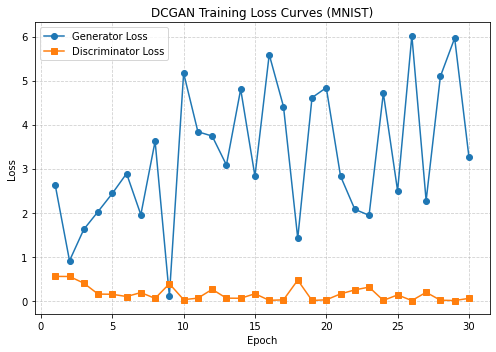

In [3]:
import matplotlib.pyplot as plt

# === Loss values copied from your DCGAN logs ===
disc_loss = [
    0.5540,0.5519,0.4012,0.1531,0.1482,0.0969,0.1868,0.0553,
    0.3870,0.0260,0.0605,0.2602,0.0600,0.0578,0.1603,0.0109,
    0.0216,0.4697,0.0078,0.0226,0.1569,0.2474,0.3110,0.0091,
    0.1337,0.0057,0.1926,0.0139,0.0059,0.0554
]

gen_loss = [
    2.6232,0.9091,1.6211,2.0253,2.4372,2.8889,1.9546,3.6222,
    0.1103,5.1676,3.8380,3.7398,3.0831,4.8024,2.8288,5.5901,
    4.4103,1.4199,4.6117,4.8379,2.8297,2.0770,1.9407,4.7150,
    2.4977,6.0194,2.2737,5.0939,5.9626,3.2695
]

epochs = range(1, len(gen_loss) + 1)

# === Plotting the Loss Curves ===
plt.figure(figsize=(7,5))
plt.plot(epochs, gen_loss, marker='o', label='Generator Loss', color='tab:blue')
plt.plot(epochs, disc_loss, marker='s', label='Discriminator Loss', color='tab:orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DCGAN Training Loss Curves (MNIST)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("results_dcgan/dcgan_loss_from_logs.png", dpi=200)
plt.show()


Figure X: Generator and Discriminator loss curves for DCGAN on MNIST.
The Generator loss exhibits strong oscillations, reflecting the adversarial dynamics as it learns to fool the Discriminator. The Discriminator loss remains consistently low, indicating it effectively distinguishes real and fake samples. This behaviour is typical for GANs, where the two networks engage in a continuous competitive process rather than converging smoothly like VAEs.

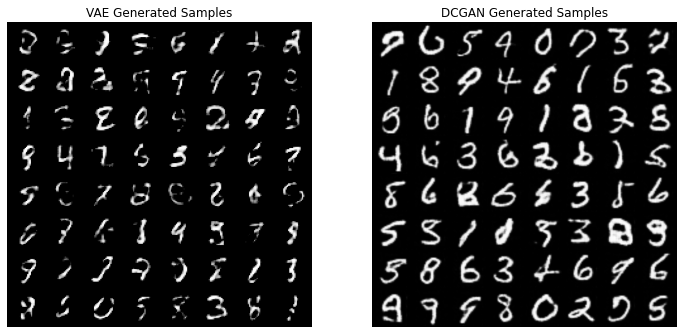

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

vae_img = Image.open("results_vae/sample_epoch20.png")
gan_img = Image.open("results_dcgan/sample_epoch30.png")

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("VAE Generated Samples")
plt.imshow(vae_img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("DCGAN Generated Samples")
plt.imshow(gan_img)
plt.axis("off")

plt.show()
